**Импорт библиотек и установка зависимостей**

In [ ]:
%pip install -r requirements.txt
import sys
sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')
%pip install \
    transformers==4.53.2 \
    triton==3.3.1 \
    typing_extensions==4.14.1 \
    tzdata==2025.2 \
    urllib3==1.25.11 \
    xxhash==3.5.0 \
    yarl==1.20.1 \
    evaluate==0.4.5 \
    seqeval==1.2.2

**Предобработка датасета и приведение к верному формату**

In [ ]:
import ast
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification
from tqdm.auto import tqdm
import random

model_name = "iiiorg/piiranha-v1-detect-personal-information"
data_file = "more_pi_dataset1.csv" 
tokenized_dataset_path = "./tokenized_log_dataset"

print("--- Шаг 1: Загрузка токенизатора и датасета ---")
tokenizer = AutoTokenizer.from_pretrained(model_name)
full_dataset = load_dataset("csv", data_files=data_file, split="train")
print("Датасет загружен. Всего записей:", len(full_dataset))


def prepare_dataset(examples):
    examples["tokens"] = [ast.literal_eval(tok_list) for tok_list in examples["mbert_tokens"]]
    examples["ner_labels"] = [ast.literal_eval(label_list) for label_list in examples["mbert_token_classes"]]
    return examples

print("\n--- Шаг 2: Преобразование строковых колонок в списки ---")
columns_to_remove = [col for col in full_dataset.column_names if col not in ['mbert_tokens', 'mbert_token_classes']]
prepared_dataset = full_dataset.map(
    prepare_dataset,
    batched=True,
    num_proc=2,
    remove_columns=columns_to_remove,
    desc="Парсинг токенов и меток"
)
print("Преобразование завершено.")

print("\n--- Шаг 2.5: Балансировка датасета (Undersampling) ---")

def has_pii(example):
    # set(example['ner_labels']) - {'O'} вернет True, если есть что-то кроме 'O'
    return bool(set(example['ner_labels']) - {'O'})

pii_dataset = prepared_dataset.filter(has_pii, num_proc=2)
no_pii_dataset = prepared_dataset.filter(lambda x: not has_pii(x), num_proc=2)

print(f"Найдено {len(pii_dataset)} записей с PII.")
print(f"Найдено {len(no_pii_dataset)} записей без PII (только 'O').")

num_pii_samples = len(pii_dataset)

if len(no_pii_dataset) > num_pii_samples:
    print(f"Уменьшаю количество записей без PII с {len(no_pii_dataset)} до {num_pii_samples}.")
    no_pii_dataset_balanced = no_pii_dataset.shuffle(seed=42).select(range(num_pii_samples))
else:
    print("Количество записей без PII уже меньше или равно количеству записей с PII. Undersampling не требуется.")
    no_pii_dataset_balanced = no_pii_dataset

# Объединяем два датасета обратно в один, теперь сбалансированный
balanced_dataset = concatenate_datasets([pii_dataset, no_pii_dataset_balanced])
# Перемешиваем финальный датасет, чтобы PII и не-PII примеры шли вперемешку
balanced_dataset = balanced_dataset.shuffle(seed=42)

print(f"Размер нового сбалансированного датасета: {len(balanced_dataset)} записей.")


# --- Получение меток из модели ---
model_config = AutoModelForTokenClassification.from_pretrained(model_name).config
id2label = {int(k): v for k, v in model_config.id2label.items()}
label2id = {v: k for k, v in id2label.items()}
print("\nСловарь меток (label2id) из модели:", label2id)


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
    )
    all_labels = []
    for i, ner_tags in enumerate(examples["ner_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                tag = ner_tags[word_idx]
                label_ids.append(label2id.get(tag, label2id["O"]))
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

print("\n--- Шаг 3: Начинаю токенизацию сбалансированных данных ---")
tokenized_datasets = balanced_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    num_proc=2,
    remove_columns=balanced_dataset.column_names,
    desc="Токенизация логов"
)
print("Токенизация завершена.")


print(f"\n--- Шаг 4: Сохраняю обработанный датасет в '{tokenized_dataset_path}' ---")
tokenized_datasets.save_to_disk(tokenized_dataset_path)
print("Подготовка данных успешно завершена!")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


--- Шаг 1: Загрузка токенизатора и датасета ---
Датасет загружен. Всего записей: 10000

--- Шаг 2: Преобразование строковых колонок в списки ---
Преобразование завершено.

--- Шаг 2.5: Балансировка датасета (Undersampling) ---
Найдено 10000 записей с PII.
Найдено 0 записей без PII (только 'O').
Количество записей без PII уже меньше или равно количеству записей с PII. Undersampling не требуется.
Размер нового сбалансированного датасета: 10000 записей.


2025-07-24 08:55:48.625657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 08:55:54.858203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Словарь меток (label2id) из модели: {'I-ACCOUNTNUM': 0, 'I-BUILDINGNUM': 1, 'I-CITY': 2, 'I-CREDITCARDNUMBER': 3, 'I-DATEOFBIRTH': 4, 'I-DRIVERLICENSENUM': 5, 'I-EMAIL': 6, 'I-GIVENNAME': 7, 'I-IDCARDNUM': 8, 'I-PASSWORD': 9, 'I-SOCIALNUM': 10, 'I-STREET': 11, 'I-SURNAME': 12, 'I-TAXNUM': 13, 'I-TELEPHONENUM': 14, 'I-USERNAME': 15, 'I-ZIPCODE': 16, 'O': 17}

--- Шаг 3: Начинаю токенизацию сбалансированных данных ---
Токенизация завершена.

--- Шаг 4: Сохраняю обработанный датасет в './tokenized_log_dataset' ---


Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:01<00:00, 8132.40 examples/s] 

Подготовка данных успешно завершена!


**Код дообучения исходной модели**

In [ ]:
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
import evaluate
import numpy as np
import pandas as pd
import torch
import warnings
from tqdm.auto import tqdm
from transformers import EarlyStoppingCallback
from transformers.trainer_callback import TrainerCallback

warnings.filterwarnings("ignore")

model_name = "iiiorg/piiranha-v1-detect-personal-information"
tokenized_dataset_path = "./tokenized_log_dataset"
output_dir = "piiranha-finetuned-logs"
final_model_path = f"{output_dir}-final"

# --- КАСТОМНЫЙ ПРОГРЕСС-БАР ---
class TqdmProgressCallback(TrainerCallback):
    def __init__(self):
        self.pbar = None
        self.current_epoch = 1
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.total_epochs = args.num_train_epochs
        total_steps = state.max_steps
        self.pbar = tqdm(total=total_steps, desc=f"Epoch {self.current_epoch}/{self.total_epochs}", 
                        leave=True, dynamic_ncols=True, position=0)
        
    def on_step_end(self, args, state, control, **kwargs):
        self.pbar.update(1)
        self.pbar.set_description(f"Epoch {self.current_epoch}/{self.total_epochs}")
        
    def on_epoch_end(self, args, state, control, **kwargs):
        self.current_epoch += 1
        
    def on_train_end(self, args, state, control, **kwargs):
        self.pbar.close()

class SaveBestModelCallback(TrainerCallback):
    """Сохраняет модель при улучшении F1-метрики"""
    def __init__(self):
        self.best_metric = None
        
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return
            
        current_metric = metrics.get("eval_f1", None)
        if current_metric is None:
            return
            
        if self.best_metric is None or current_metric > self.best_metric:
            self.best_metric = current_metric
            trainer.model.save_pretrained(f"{output_dir}/best_model")
            trainer.tokenizer.save_pretrained(f"{output_dir}/best_model")
            print(f"\nНовая лучшая модель сохранена с F1: {current_metric:.4f}")

print("Загружаю подготовленный датасет...")
tokenized_datasets_from_disk = load_from_disk(tokenized_dataset_path)
dataset_dict = tokenized_datasets_from_disk.train_test_split(test_size=0.2, seed=42)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

seqeval = evaluate.load("seqeval")
label_list = list(model.config.id2label.values())

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    per_class_results = {}
    for key, value in results.items():
        if isinstance(value, dict) and 'f1-score' in value:
             per_class_results[f"eval_{key}_f1"] = value['f1-score']
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
        **per_class_results
    }

# --- НАСТРОЙКИ ОБУЧЕНИЯ ---
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    disable_tqdm=True,  # Отключаем стандартный прогресс-бар
)

# --- ИНИЦИАЛИЗАЦИЯ ТРЕНЕРА ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        TqdmProgressCallback(),  # кастомный прогресс-бар
        EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001),
        SaveBestModelCallback(),
    ],
)

# --- ЗАПУСК ОБУЧЕНИЯ ---
print("Начинаю дообучение модели...")
try:
    train_result = trainer.train()
    trainer.save_model(final_model_path)
    print(f"\nОбучение завершено. Лучшая модель сохранена в '{final_model_path}'")
except Exception as e:
    print(f"\nОшибка обучения: {str(e)}")
    trainer.save_model(f"{output_dir}/error_save")
    raise

# --- АНАЛИЗ РЕЗУЛЬТАТОВ ---
def show_predictions(model_path, num_examples=5):
    print("\n--- Точный анализ предсказаний ---")
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    test_set = dataset_dict["test"]
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    for i in range(num_examples):
        if i >= len(test_set): break
        
        example = test_set[i]
        input_ids = torch.tensor(example['input_ids']).unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            logits = model(input_ids).logits
        
        predictions = torch.argmax(logits, dim=2).squeeze().tolist()
        tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
        true_labels = [label_list[l] if l != -100 else "PAD" for l in example['labels']]
        pred_labels = [label_list[p] for p in predictions]
        
        df = pd.DataFrame({
            'Токен': tokens, 
            'Реальная метка': true_labels, 
            'Предсказание': pred_labels
        })
        
        df_filtered = df[(df['Реальная метка'] != 'PAD') & (~df['Токен'].isin(['[CLS]', '[SEP]', '[PAD]']))]
        mismatches = df_filtered[df_filtered['Реальная метка'] != df_filtered['Предсказание']]
        real_pii = df_filtered[df_filtered['Реальная метка'] != 'O']
        
        display_df = pd.concat([real_pii, mismatches]).drop_duplicates().sort_index()

        print(f"\n--- Пример #{i+1} ---")
        print(display_df.to_string() if not display_df.empty else "Нет расхождений")

show_predictions(f"{output_dir}/best_model", num_examples=5)

Загружаю подготовленный датасет...


Начинаю дообучение модели...


Epoch 1/15:   7%|▋         | 1000/15000 [03:42<48:58,  4.76it/s]

{'loss': 0.068, 'grad_norm': 0.5892728567123413, 'learning_rate': 2.8002e-05, 'epoch': 1.0}
{'eval_loss': 0.05032898113131523, 'eval_precision': 0.8151587777112043, 'eval_recall': 0.7130503144654088, 'eval_f1': 0.7606933184232598, 'eval_accuracy': 0.9858660756819453, 'eval_runtime': 19.7525, 'eval_samples_per_second': 101.253, 'eval_steps_per_second': 12.657, 'epoch': 1.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Новая лучшая модель сохранена с F1: 0.7607


Epoch 2/15:  13%|█▎        | 2000/15000 [12:29<42:51,  5.06it/s]    

{'loss': 0.0413, 'grad_norm': 0.13303525745868683, 'learning_rate': 2.6002000000000003e-05, 'epoch': 2.0}
{'eval_loss': 0.03957774117588997, 'eval_precision': 0.8138009694895922, 'eval_recall': 0.7479035639412998, 'eval_f1': 0.7794619691383312, 'eval_accuracy': 0.9874899028603384, 'eval_runtime': 19.9079, 'eval_samples_per_second': 100.463, 'eval_steps_per_second': 12.558, 'epoch': 2.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Новая лучшая модель сохранена с F1: 0.7795


Epoch 3/15:  20%|██        | 3000/15000 [21:17<39:51,  5.02it/s]    

{'loss': 0.0331, 'grad_norm': 0.6952054500579834, 'learning_rate': 2.4002e-05, 'epoch': 3.0}
{'eval_loss': 0.031936757266521454, 'eval_precision': 0.8451594369434071, 'eval_recall': 0.7709643605870021, 'eval_f1': 0.8063587775798274, 'eval_accuracy': 0.9890184544644891, 'eval_runtime': 19.7786, 'eval_samples_per_second': 101.12, 'eval_steps_per_second': 12.64, 'epoch': 3.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Новая лучшая модель сохранена с F1: 0.8064


Epoch 4/15:  27%|██▋       | 4000/15000 [30:06<35:11,  5.21it/s]    

{'loss': 0.0283, 'grad_norm': 0.19728584587574005, 'learning_rate': 2.2002e-05, 'epoch': 4.0}
{'eval_loss': 0.027988409623503685, 'eval_precision': 0.8369074492099323, 'eval_recall': 0.7772536687631028, 'eval_f1': 0.8059782608695653, 'eval_accuracy': 0.9897972287235144, 'eval_runtime': 19.8642, 'eval_samples_per_second': 100.683, 'eval_steps_per_second': 12.585, 'epoch': 4.0}


Epoch 5/15:  33%|███▎      | 5000/15000 [37:37<34:12,  4.87it/s]    

{'loss': 0.0243, 'grad_norm': 1.8459597826004028, 'learning_rate': 2.0002e-05, 'epoch': 5.0}
{'eval_loss': 0.030786648392677307, 'eval_precision': 0.8106525376464027, 'eval_recall': 0.7617924528301887, 'eval_f1': 0.7854633882734396, 'eval_accuracy': 0.9890805907085602, 'eval_runtime': 19.8603, 'eval_samples_per_second': 100.703, 'eval_steps_per_second': 12.588, 'epoch': 5.0}


Epoch 6/15:  40%|████      | 6000/15000 [45:08<31:37,  4.74it/s]    

{'loss': 0.0211, 'grad_norm': 0.21670502424240112, 'learning_rate': 1.8001999999999998e-05, 'epoch': 6.0}
{'eval_loss': 0.03078075498342514, 'eval_precision': 0.8249721293199554, 'eval_recall': 0.7756813417190775, 'eval_f1': 0.7995678011885468, 'eval_accuracy': 0.9895693958285868, 'eval_runtime': 19.7849, 'eval_samples_per_second': 101.087, 'eval_steps_per_second': 12.636, 'epoch': 6.0}


Epoch 6/15:  40%|████      | 6000/15000 [49:17<1:13:55,  2.03it/s]

{'train_runtime': 2957.1776, 'train_samples_per_second': 40.579, 'train_steps_per_second': 5.072, 'train_loss': 0.03603735987345378, 'epoch': 6.0}



Обучение завершено. Лучшая модель сохранена в 'piiranha-finetuned-logs-final'

--- Точный анализ предсказаний ---

--- Пример #1 ---
    Токен Реальная метка Предсказание
141    ▁4     I-PASSWORD   I-PASSWORD
142   ▁##     I-PASSWORD   I-PASSWORD
146    ▁#     I-PASSWORD   I-PASSWORD
162   ▁##     I-USERNAME   I-USERNAME

--- Пример #2 ---
        Токен Реальная метка Предсказание
62        ▁##        I-EMAIL      I-EMAIL
69   ▁example        I-EMAIL      I-EMAIL
70          ▁        I-EMAIL      I-EMAIL
77        ▁##     I-USERNAME   I-USERNAME
110        ▁K     I-PASSWORD            O
111       ▁##     I-PASSWORD   I-PASSWORD
113        ▁W     I-PASSWORD   I-PASSWORD
118        ▁5     I-PASSWORD   I-PASSWORD

--- Пример #3 ---
        Токен Реальная метка Предсказание
98        ▁##        I-EMAIL      I-EMAIL
102  ▁example        I-EMAIL      I-EMAIL
103      ▁net        I-EMAIL      I-EMAIL
115       ▁##     I-PASSWORD   I-PASSWORD
117       ▁MX     I-PASSWORD   I-PASSWORD
122     

**Визуализация метрик**

 - Accuracy
 - Precision
 - F1
 - validation Loss


--- Построение графиков обучения ---


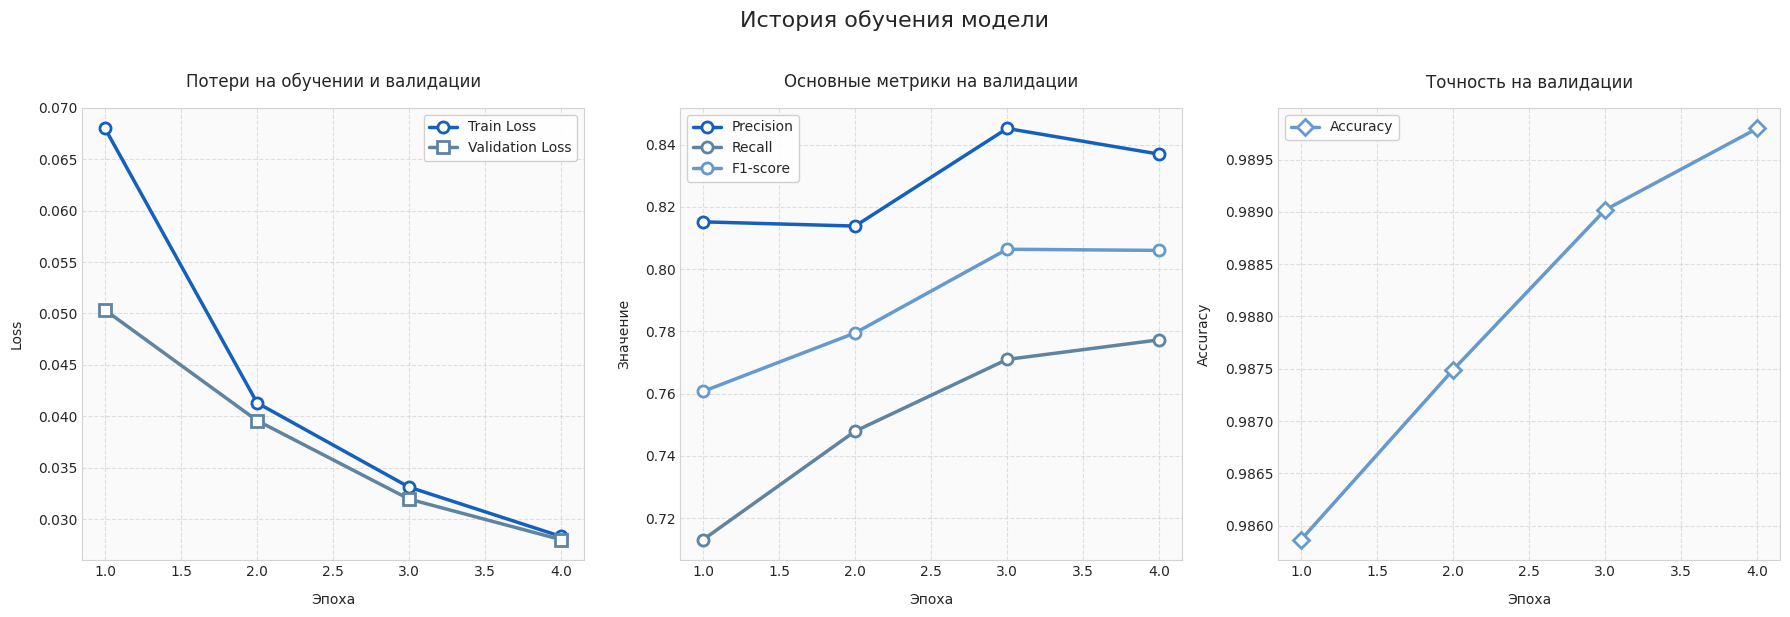

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_training_history(log_history):
    print("\n--- Построение графиков обучения ---")
    
    COLORS = {
        'blue_grey': '#6699CC',
        'dusky_blue': '#5F84A2',
        'denim': '#1560BD',
        'light_grey': '#D3D3D3',
        'dark_grey': '#5A5A5A'
    }
    
    logs = [log for log in log_history[:-5] if 'loss' in log or 'eval_loss' in log]
    df = pd.DataFrame(logs)

    train_df = df[df['loss'].notna()].reset_index(drop=True)
    eval_df = df[df['eval_loss'].notna()].reset_index(drop=True)

    sns.set_style("whitegrid")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        COLORS['denim'], 
        COLORS['dusky_blue'], 
        COLORS['blue_grey']
    ])
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('История обучения модели', fontsize=16, y=1.02)

    axs[0].plot(train_df['epoch'], train_df['loss'], 
               label='Train Loss', 
               linewidth=2.5,
               color=COLORS['denim'],
               marker='o',
               markersize=8,
               markerfacecolor='white',
               markeredgecolor=COLORS['denim'],
               markeredgewidth=2)
    
    axs[0].plot(eval_df['epoch'], eval_df['eval_loss'], 
               label='Validation Loss', 
               linewidth=2.5,
               color=COLORS['dusky_blue'],
               marker='s',
               markersize=8,
               markerfacecolor='white',
               markeredgecolor=COLORS['dusky_blue'],
               markeredgewidth=2)
    
    axs[0].set_title('Потери на обучении и валидации', pad=15)
    axs[0].set_xlabel('Эпоха', labelpad=10)
    axs[0].set_ylabel('Loss', labelpad=10)
    axs[0].grid(color=COLORS['light_grey'], linestyle='--', alpha=0.7)
    axs[0].legend(framealpha=0.9)

    metrics = {
        'eval_precision': {'label': 'Precision', 'color': COLORS['denim']},
        'eval_recall': {'label': 'Recall', 'color': COLORS['dusky_blue']},
        'eval_f1': {'label': 'F1-score', 'color': COLORS['blue_grey']}
    }
    
    for metric, style in metrics.items():
        axs[1].plot(eval_df['epoch'], eval_df[metric], 
                   label=style['label'], 
                   linewidth=2.5,
                   color=style['color'],
                   marker='o',
                   markersize=8,
                   markerfacecolor='white',
                   markeredgecolor=style['color'],
                   markeredgewidth=2)
    
    axs[1].set_title('Основные метрики на валидации', pad=15)
    axs[1].set_xlabel('Эпоха', labelpad=10)
    axs[1].set_ylabel('Значение', labelpad=10)
    axs[1].grid(color=COLORS['light_grey'], linestyle='--', alpha=0.7)
    axs[1].legend(framealpha=0.9)

    # 3. График точности (Accuracy)
    axs[2].plot(eval_df['epoch'], eval_df['eval_accuracy'], 
               label='Accuracy', 
               linewidth=2.5,
               color=COLORS['blue_grey'],
               marker='D',
               markersize=8,
               markerfacecolor='white',
               markeredgecolor=COLORS['blue_grey'],
               markeredgewidth=2)
    
    axs[2].set_title('Точность на валидации', pad=15)
    axs[2].set_xlabel('Эпоха', labelpad=10)
    axs[2].set_ylabel('Accuracy', labelpad=10)
    axs[2].grid(color=COLORS['light_grey'], linestyle='--', alpha=0.7)
    axs[2].legend(framealpha=0.9)

    # Общие настройки
    for ax in axs:
        ax.spines['top'].set_color(COLORS['light_grey'])
        ax.spines['right'].set_color(COLORS['light_grey'])
        ax.spines['left'].set_color(COLORS['light_grey'])
        ax.spines['bottom'].set_color(COLORS['light_grey'])
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_facecolor('#FAFAFA')
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.state.log_history)